# Analítica de Negocios y Ciencia de Datos

## CIDE - Otoño 2015

### Solución Tarea 5: Regresión Lineal


### Problema 1: Algoritmo de Backfitting

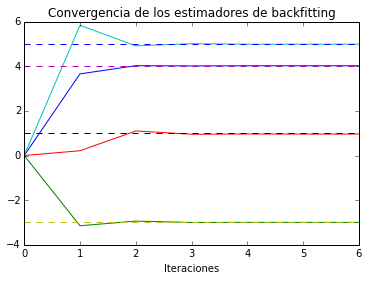

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/danielvaughan/Documents/Python Scripts')
import olsdan as ols
%matplotlib inline

# Simulemos el modelo
N = 100
np.random.seed(3341309)
x1 = 2*np.random.randn(N,1)
x2 = 0.5*np.random.randn(N,1)
x3 = 1*np.random.randn(N,1)
betatrue = np.array([4,-3,1,5]).reshape((4,1))

# listos
xmat = np.concatenate((np.ones((N,1)),x1,x2,x3),axis=1)
y = np.dot(xmat,betatrue) + np.random.randn(N,1)

dist = 10000
beta = np.zeros((1,4))
#beta[:,:] = np.nan
counter = 0
while dist > 0.01:
    prebeta = np.zeros((1,4))
    for k in range(4):
        # la nueva variable dependiente debe estar limpia de otros regresores utilizando la estimación actual
        ind_exc = np.setdiff1d(np.arange(4),np.array([k]))
        yk = y - np.dot(xmat[:,ind_exc],beta[-1,ind_exc].reshape((3,1)))
        # Entra un regresor nuevo
        xk = xmat[:,k].reshape((N,1))
        olsk = ols.ols_dan(yk,xk)
        prebeta[0,k] = olsk.betahat()[0]
    # Actualicemos beta
    beta = np.concatenate((beta,prebeta),axis=0)
    # Actualicemos la distancia:
    if counter > 1:
        dist = np.abs(np.max(beta[counter,:] - beta[counter-1,:]))
    counter +=1
    
ax = pd.DataFrame(beta).plot()
xmin,xmax = plt.xlim()
for k in range(4):
    plt.plot([0,xmax],[betatrue[k],betatrue[k]], ls='--')
ax.legend_.remove()
ax.set_title(u'Convergencia de los estimadores de backfitting')
#ax.set_xticks(np.arange(beta.shape[0]),np.arange(beta.shape[0]))
ax.set_xlabel('Iteraciones')

# Problema 2: Best Subset Selection y Validación Cruzada

**Parte 1**

In [8]:
# best subset selection: using cross-validation
data = pd.read_csv('datasets/Credit.csv')
data.head()

# primero organicemos los datos: las variables cuantitativas están bien.  Las cualitativas toca transformarlas
N = data.shape[0]
dum_hombre     = np.asarray(data.Gender == ' Male').reshape((N,1))
dum_estudiante = np.asarray(data.Student == 'Yes').reshape((N,1))
dum_casado     = np.asarray(data.Married == 'Yes').reshape((N,1))
# Para etnicidad debemos excluir una variable que sirva como referencia:
# tenemos tres categorías: vamos a excluir la tercera: "African American"
print data.Ethnicity.unique()
dum_ethnic = np.asarray(pd.get_dummies(data.Ethnicity).iloc[:,:-1])
# etiquetas de X
labs_x = np.array(['Rating','Income','Limit','Cards','Age','Education',
              'Hombre','Estudiante','Casado','Caucasian','Asian'])
# incluyamos todas las variables:
prexmat = np.concatenate((
                        np.asarray(data.Rating).reshape((N,1)),
                        np.asarray(data.Income).reshape((N,1)),
                         np.asarray(data.Limit).reshape((N,1)),
                         np.asarray(data.Cards).reshape((N,1)),
                         np.asarray(data.Age).reshape((N,1)),
                         np.asarray(data.Education).reshape((N,1)),
                          dum_hombre, dum_estudiante, dum_casado, dum_ethnic
                         ),axis=1)
saldo = np.asarray(data.Balance).reshape((N,1))
print prexmat.shape
# revisemos que todo quedó bien:
pd.DataFrame(prexmat).mean()

['Caucasian' 'Asian' 'African American']
(400, 11)


0      354.940000
1       45.218885
2     4735.600000
3        2.957500
4       55.667500
5       13.450000
6        0.482500
7        0.100000
8        0.612500
9        0.247500
10       0.255000
dtype: float64

In [10]:
# Para las posibles combinaciones vamos a usar el módulo itertools
from itertools import combinations
#import sys
#sys.path.append('/Users/danielvaughan/Documents/Python Scripts')
#import olsdan as ols

# probémoslo con conjuntos de 9 elementos
list(combinations(np.arange(10),9))

# vamos a guardar los resultados en un array, pero no se cuántas filas tenemos
res_arr = np.zeros((1,6))
res_arr[:,:] = np.nan
# necesito una lista con todas las combinaciones.  La voy a guardar en un DF
initsub = np.zeros((0,9))
initsub[:] = np.nan
SubSets = pd.DataFrame(initsub)
for k in range(1,12):
    # la siguiente es la lista de todos los regresores posibles para tamaño k
    list_subsets = list(combinations(np.arange(11),k))
    SubSets = SubSets.append(list_subsets)
    # tenemos que hacer un loop sobre todas estas posibilidades:
    for s in range(len(list_subsets)):
        # los regresores seleccionados:
        ind_s = np.array(list_subsets[s])
        xmat_subset = prexmat[:,ind_s]
        # listos para estimar: pero incluyamos constante
        olssk = ols.ols_dan(saldo, np.concatenate((np.ones((N,1)),xmat_subset),axis=1))
        # guardemos los resultados: queremos: número de regresores, ssr
        # Calculemos las medidas que queremos utilizar
        Cp = olssk.ssr() + (1.0/olssk.nobs)*(2*olssk.nvar*olssk.s2hat())
        AIC = (1.0/(olssk.nobs))*(olssk.ssr() + 2*olssk.nvar*olssk.s2hat())
        BIC = (1.0/olssk.nobs)*(olssk.ssr() + np.log(olssk.nobs)*olssk.nvar*olssk.s2hat())
        R2bar = olssk.R2_bar()
        prelist = np.array([k, olssk.ssr(), Cp[0,0], AIC[0,0], BIC[0,0], R2bar]).reshape((1,6))
        # listos para anexar:
        res_arr = np.concatenate((res_arr, prelist),axis=0)
res_arr = pd.DataFrame(res_arr, columns=['k', 'SSR', 'Cp', 'AIC', 'BIC', 'R2bar'])
res_arr.dropna(inplace=True)
res_arr.set_index(np.arange(res_arr.shape[0]), inplace=True)
print res_arr.shape

(2047, 6)


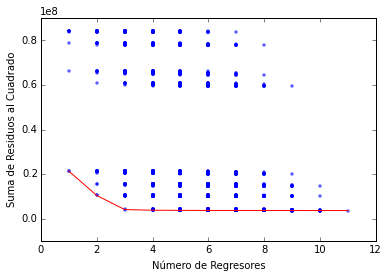

In [12]:
# Ya tenemos todos los modelos:
# Hagamos un gráfico:
plt.scatter(res_arr.k,res_arr.SSR, s=6, color='b',alpha=0.5)
plt.ylabel('Suma de Residuos al Cuadrado')
plt.xlabel(u'Número de Regresores')
# Encontremos la frontera:
front_ssr = res_arr.SSR.groupby(res_arr.k).min()
plt.plot(front_ssr.index, front_ssr.values, color='r')                          

Int64Index([0, 11, 71, 354, 564, 1025, 1490, 1826, 1990, 2035, 2046], dtype='int64')


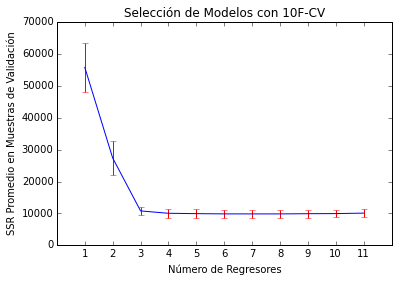

In [13]:
# Cross-validation: necesitamos identificar primero los modelos en la frontera roja
# identifiquemos los índices primero: función np.in1d()
ind_best = np.in1d(res_arr.SSR.values,front_ssr.values)
# teniendo los índices podemos encontrar: los 10 mejores
ind_best = res_arr.index[ind_best]
print ind_best
# Vamos a hacer 10-fold CV así que asignemos grupos.
grp_sel = np.dot(np.random.multinomial(1,[1.0/10]*10,N),np.arange(1,11).reshape((10,1)))
# Inicialicemos la matriz donde vamos a guardar los resultados.
SSRCV = np.zeros((10,11))  # CV groups x Number of variables
# Teníamos unos índices equivocados.  Vamos a hacerlo de 0 a M (M es el número total de modelos o combinaciones)
SubSets.set_index(np.arange(SubSets.shape[0]), inplace=True)
# Primer loop es sobre grupos de validación: g es el grupo que vamos a excluir de la muestra entrenamiento.
for g in range(1,11):
    # Seleccionemos las muestras desde ya
    ind_train = (grp_sel!=g).flatten()
    nobs_train = ind_train.sum()
    ind_valid = (grp_sel==g).flatten()
    nobs_valid = ind_valid.sum()
    # Ahora el loop sobre los modelos:
    counter = 0
    for m in ind_best:
        # Seleccionemos el modelo correspondiente sobre la frontera: necesitamos los índices de las variables
        ind_s = np.array(pd.Series(SubSets.ix[m]).dropna().values,dtype='int')
        # Asignemos la matrix X correspondiente
        xmat_subset = np.concatenate((np.ones((N,1)),prexmat[:,ind_s]),axis=1)
        # Restrinjamos la estimación a grupos de entrenamiento y validación
        xmat_train = xmat_subset[ind_train,:]
        xmat_valid = xmat_subset[ind_valid,:]
        y_train    = saldo[ind_train].reshape((nobs_train,1))
        y_valid    = saldo[ind_valid].reshape((nobs_valid,1))
        # La estimación es sobre TRAINING únicamente
        olssk = ols.ols_dan(y_train, xmat_train)
        # Obtengamos el resultado de la estimación sobre validación
        nvar  = olssk.nvar
        yhat_valid = np.dot(xmat_valid,olssk.betahat().reshape(nvar,1))
        diff       = y_valid - yhat_valid
        ssr_valid  = np.dot(diff.T,diff)/nobs_valid
        # Guardemos
        SSRCV[g-1,counter] = ssr_valid[0,0]
        counter +=1
# Listo:
# Ready to plot:
SSRCVm   = pd.DataFrame(SSRCV).mean(axis=0)
SSRCVstd = pd.DataFrame(SSRCV).sem(axis=0)
# plot SSRCV and std errors
plt.plot(np.arange(1,12), SSRCVm.values, color='b')
plt.bar(np.arange(1,12), SSRCVm.values, color='w', ec='w',yerr=1.96*SSRCVstd, ecolor='r', align='center')
plt.title(u'Selección de Modelos con 10F-CV')
plt.xticks(np.arange(1,12), np.arange(1,12))
plt.xlabel(u'Número de Regresores')
plt.ylabel(u'SSR Promedio en Muestras de Validación')